# Multiclass Text Classification with TF-IDF

We work with a sample from the actual dataset containing consumer complaints. The full dataset could be found [here](https://catalog.data.gov/dataset/consumer-complaint-database).

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df=pd.read_csv('/content/drive/MyDrive/movies.csv')

### Exploration and Preprocessing

In [4]:
df.head(10) #this way you can display columns as rows.

Unnamed: 0        genre                                        description
0           0        drama  Listening in to a conversation between his doc...
1           1     thriller  A brother and sister with a past incestuous re...
2           2        adult  As the bus empties the students for their fiel...
3           3        drama  To help their unemployed father make ends meet...
4           4        drama  The film's title refers not only to the un-rec...
5           5  documentary  Quality Control consists of a series of 16mm s...
6           6       comedy  In tough economic times Max and Joey have all ...
7           7        crime  Ron Petrie (Keanu Reeves) is a troubled teen w...
8           8   reality-tv  A sudden calamitous event, causing great loss ...
9           9       horror  Four high school students embark on a terrifyi...

In [5]:
# Create a new dataframe with two columns
df1 = df[['genre','description']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['description'])]

# Renaming second column for a simpler name
#df1.columns = ['Product', 'Complaint']

df1.shape

(54214, 2)

In [6]:
# Percentage of complaints that had text field
total = df1['description'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [7]:
pd.DataFrame(df.genre.unique()).values

array([['drama'],
       ['thriller'],
       ['adult'],
       ['documentary'],
       ['comedy'],
       ['crime'],
       ['reality-tv'],
       ['horror'],
       ['sport'],
       ['animation'],
       ['action'],
       ['fantasy'],
       ['short'],
       ['sci-fi'],
       ['music'],
       ['adventure'],
       ['talk-show'],
       ['western'],
       ['family'],
       ['mystery'],
       ['history'],
       ['news'],
       ['biography'],
       ['romance'],
       ['game-show'],
       ['musical'],
       ['war']], dtype=object)

In [38]:
# let's work with a smaller smaple of the data to speed things up
df2 = df1.sample(20000, random_state=2).copy()

In [39]:
pd.DataFrame(df2.genre.unique())
df2.genre.value_counts()

drama          5012
documentary    4808
comedy         2746
short          1836
horror          836
thriller        580
action          485
western         360
reality-tv      344
adventure       301
family          283
romance         256
music           251
adult           238
sci-fi          223
crime           202
animation       190
sport           171
talk-show       142
fantasy         136
mystery         124
biography        99
musical          97
history          97
game-show        70
news             68
war              45
Name: genre, dtype: int64

In [35]:
# Get the count of each genre
genre_counts = df2.genre.value_counts()

# Identify genres with count less than 10
genres_to_replace = genre_counts[genre_counts < 400].index

# Replace these genres with 'other'
df2.loc[df2.genre.isin(genres_to_replace), 'genre'] = 'other'

# Check the result
print(df2.genre.value_counts())

drama          5012
documentary    4808
other          3697
comedy         2746
short          1836
horror          836
thriller        580
action          485
Name: genre, dtype: int64


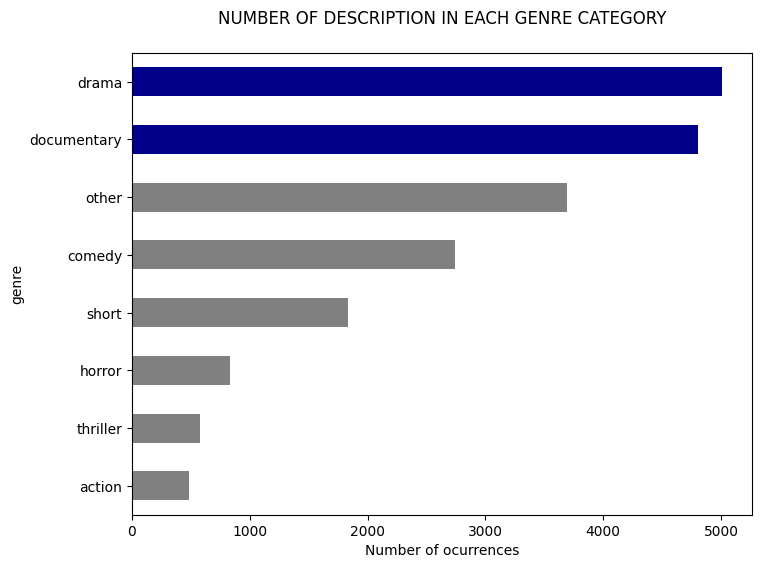

In [36]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('genre').description.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF DESCRIPTION IN EACH GENRE CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [37]:
# Create a new column 'category_id' with encoded categories
df2['genre_id'] = df2['genre'].factorize()[0]
category_id_df = df2[['genre', 'genre_id']].drop_duplicates()


# Dictionaries for future use
genre_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['genre_id', 'genre']].values)

# New dataframe
df2.head()

genre                                        description  genre_id
49672   drama  A bizarre couple and their seventeen-year-old ...         0
48949   short  The world has been taken over by The Unknown. ...         1
15204   drama  The drama tells the story about a variety of e...         0
41474  comedy  Petr Vok ('Martin Ruzek' (qv)) changes entirel...         2
39976  horror  Jeremy moves his family consisting of his son ...         3

Let us now calculate TF-IDF scores.

In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.description).toarray()

labels = df2.genre_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 15660 features (TF-IDF score of unigrams and bigrams)


In [14]:
# Finding the three most correlated terms with each of the product categories
N = 3
for genre, genre_id in sorted(genre_to_id.items()):
  features_chi2 = chi2(features, labels == genre_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(genre))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> comedy:
  * Most Correlated Unigrams are: sketch, hilarious, comedy
  * Most Correlated Bigrams are: comedy series, romantic comedy, sketch comedy

==> documentary:
  * Most Correlated Unigrams are: history, interviews, documentary
  * Most Correlated Bigrams are: documentary follows, documentary explores, documentary film

==> drama:
  * Most Correlated Unigrams are: mother, father, son
  * Most Correlated Bigrams are: young man, young woman, year old

==> horror:
  * Most Correlated Unigrams are: evil, vampire, horror
  * Most Correlated Bigrams are: survive night, group college, horror film

==> other:
  * Most Correlated Unigrams are: gang, documentary, ranch
  * Most Correlated Bigrams are: american academy, half hour, bound gagged

==> short:
  * Most Correlated Unigrams are: sobre, documental, short
  * Most Correlated Bigrams are: making piece, dan bell, short film


### Classification

We start with a train-test split.

In [15]:
X = df2['description'] # Collection of documents
y = df2['genre'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
print(df2['genre'].unique)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 20)

<bound method Series.unique of 49672          drama
48949          short
15204          drama
41474         comedy
39976         horror
            ...     
1796     documentary
8323           drama
14471          other
2944     documentary
39148          other
Name: genre, Length: 10000, dtype: object>




*   Linear Support Vector Machine


In [16]:
models = [
    LinearSVC()
]

# 10 Cross-validation
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Mean Accuracy  Standard deviation
model_name                                   
LinearSVC          0.5697            0.014545

Evaluation

In [19]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(df2['genre'].unique())
print(y_pred)
print(metrics.classification_report(y_test, y_pred,target_names= df2['genre'].unique()))

				CLASSIFICATIION METRICS

['drama' 'short' 'comedy' 'horror' 'documentary' 'other']
[0 5 5 ... 5 2 0]
              precision    recall  f1-score   support

       drama       0.53      0.64      0.58       612
       short       0.40      0.21      0.27       233
      comedy       0.49      0.44      0.47       334
      horror       0.82      0.44      0.57       121
 documentary       0.68      0.75      0.71       596
       other       0.53      0.53      0.53       604

    accuracy                           0.56      2500
   macro avg       0.57      0.50      0.52      2500
weighted avg       0.56      0.56      0.55      2500



Confusion Matrix

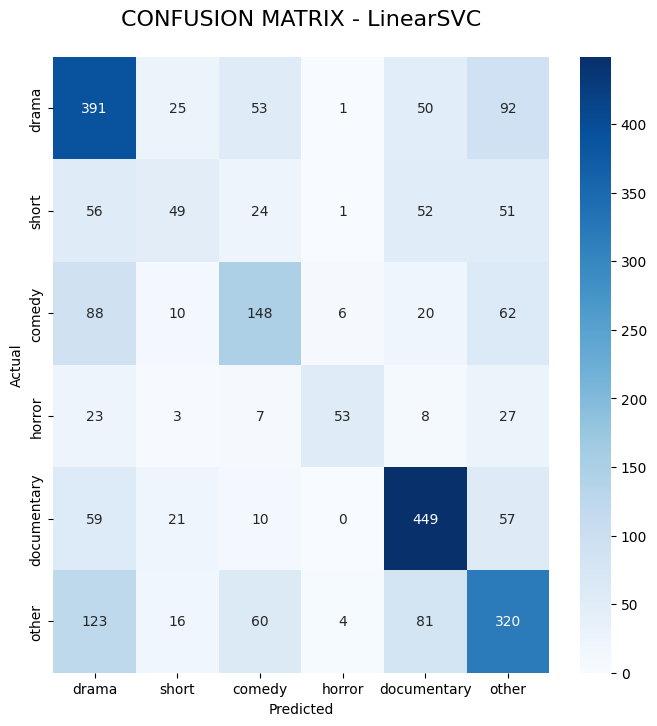

In [21]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.genre.values,
            yticklabels=category_id_df.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

### Analysing Results

Let’s have a look at the texts that were wrongly classified.

In [23]:
for predicted in category_id_df.genre_id:
  for actual in category_id_df.genre_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))



'short' predicted as 'drama' : 56 examples.
'comedy' predicted as 'drama' : 88 examples.
'horror' predicted as 'drama' : 23 examples.
'documentary' predicted as 'drama' : 59 examples.
'other' predicted as 'drama' : 123 examples.
'drama' predicted as 'short' : 25 examples.
'documentary' predicted as 'short' : 21 examples.
'drama' predicted as 'comedy' : 53 examples.
'short' predicted as 'comedy' : 24 examples.
'other' predicted as 'comedy' : 60 examples.
'drama' predicted as 'documentary' : 50 examples.
'short' predicted as 'documentary' : 52 examples.
'comedy' predicted as 'documentary' : 20 examples.
'other' predicted as 'documentary' : 81 examples.
'drama' predicted as 'other' : 92 examples.
'short' predicted as 'other' : 51 examples.
'comedy' predicted as 'other' : 62 examples.
'horror' predicted as 'other' : 27 examples.
'documentary' predicted as 'other' : 57 examples.


Most correlated terms with each category¶


In [24]:
model.fit(features, labels)

N = 4
for genre, genre_id in sorted(genre_to_id.items()):
  indices = np.argsort(model.coef_[genre_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(genre))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'comedy':
  * Top unigrams: comedy, hilarious, funny, doesn
  * Top bigrams: high school, middle aged, little town, best friends

==> 'documentary':
  * Top unigrams: documentary, portrait, years, people
  * Top bigrams: film follows, children living, past present, 40 years

==> 'drama':
  * Top unigrams: drama, son, happiness, lives
  * Top bigrams: feature film, ordinary man, family soon, older woman

==> 'horror':
  * Top unigrams: horror, vampire, evil, flesh
  * Top bigrams: group teenagers, fall victim, group college, place called

==> 'other':
  * Top unigrams: thriller, ranch, adventure, alien
  * Top bigrams: way make, fbi agent, mr right, gets caught

==> 'short':
  * Top unigrams: short, morning, wear, sized
  * Top bigrams: short film, short documentary, making piece, just returned


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's come up with a new Description and see how our model does.



In [26]:
new_description = """An eye-opening exploration of the Great Barrier Reef, showcasing its stunning beauty and the looming threats it faces from climate change. Interviews with scientists and activists underscore the urgent need for conservation."""
print(model.predict(fitted_vectorizer.transform([new_description])))

['documentary']
